### MSc Thesis: BEB's CRMs MFA 

Author: Che (Chester) Xiao

This Jupyter Notebook sets up a dynamic MFA analysis for a BEB fleet, with a focus on its CRMs.\

It loads **configuration** and **custom functions**, sets up the **ODYM system**, computes the dynamic stock model (DSM)
for BEB fleet dynamics, calculates the recovered and unrecovered CRM flows under different recycling scenarios,
and exports/plots the results.

### Section 1: Load Modules & Set Paths

In [1]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import openpyxl
import json
import jsonschema

# Render matplotlib plots directly inline in the notebook
%matplotlib inline

In [2]:
# Load configuration from JSON file to externalise all study parameters
config_file = os.path.join(os.getcwd(), "config_ODYM.json")



with open(config_file, "r") as f:
    config = json.load(f)

In [3]:
# Define paths from configuration
# MainPath = config["paths"]["modules"]
# DataPath = config["paths"]["data"]

MainPath = os.path.join(os.getcwd(), config["paths"]["modules"])
DataPath = os.path.join(os.getcwd(), config["paths"]["data"])
results_folder = os.path.join(os.getcwd(), config["paths"]["results"])
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

# Add ODYM modules path
sys.path.insert(0, MainPath)

# Import ODYM modules and custom BEB functions module
import ODYM_Classes as msc
import ODYM_Functions as msf
import dynamic_stock_model as dsm
import functions_ODYM as bf  # custom BEB functions

### Section 2: Define Classifications & Build Index Table

In [4]:
# from **beb_functions**
MyYears = list(range(config["time"]["start"], config["time"]["end"] + 1)) # year 2026-2050


# Create classifications for the MFA system using ODYM classes
ModelClassification = {}
ModelClassification['Time'] = msc.Classification(Name='Time', Dimension='Time', ID=1, Items=MyYears)
ModelClassification['Cohort'] = msc.Classification(Name='Age-cohort', Dimension='Time', ID=2, Items=MyYears)
ModelClassification['Element'] = msc.Classification(Name='Elements', Dimension='Element', ID=3, Items=config["crm"]["elements"])
ModelClassification['Region'] = msc.Classification(Name='Regions', Dimension='Region', ID=4, Items=['EU City'])


# Build the index table (a DataFrame) that ODYM uses to map aspects to dimensions
IndexTable = pd.DataFrame({
    'Aspect': ['Time', 'Age-cohort', 'Element', 'Region'],
    'Description': ['Model aspect "time"', 'Model aspect "age-cohort"', 'Model aspect "Element"', 'Model aspect "Region"'],
    'Dimension': ['Time', 'Time', 'Element', 'Region'],
    'Classification': [ModelClassification[a] for a in ['Time', 'Cohort', 'Element', 'Region']],
    'IndexLetter': ['t', 'c', 'e', 'r']
})

IndexTable.set_index('Aspect', inplace=True)
IndexTable



,Description,Dimension,Classification,IndexLetter
Aspect,,,,
Time,"Model aspect ""time""",Time,<ODYM_Classes.Classification object at 0x00000...,t
Age-cohort,"Model aspect ""age-cohort""",Time,<ODYM_Classes.Classification object at 0x00000...,c
Element,"Model aspect ""Element""",Element,<ODYM_Classes.Classification object at 0x00000...,e
Region,"Model aspect ""Region""",Region,<ODYM_Classes.Classification object at 0x00000...,r



## Section 3: Define Case Study Parameters & Flow Functions

This study simulates the introduction of a fleet (100 BEBs) between 2025 to 2035 and traces their impacts till 2050.

**The recycling_rate function is in the beb_functions module and accepts parameters from configuration.**


In [5]:
# from **beb_functions**

# Set lifetime distribution parameters, Weibull model
lifetime_dict = {
    'Type': config["lifetime"]["Type"],
    'Shape': np.array([config["lifetime"]["Shape"]]),
    'Scale': np.array([config["lifetime"]["Scale"]])
}

# Define battery mass per bus (kg) and CRM intensities as fractions
battery_mass = config["battery"]["mass"]
crm_intensities = config["crm"]["intensities"]

# Compute absolute CRM mass per bus (kg)
crm_mass_per_bus = {m: battery_mass * p for m, p in crm_intensities.items()}


print("Lifetime distribution parameters:", lifetime_dict)
print("Battery mass per bus:", battery_mass, "kg")
print("CRM intensity:", crm_intensities)
print("CRM mass per battery/bus:", crm_mass_per_bus)


Lifetime distribution parameters: {'Type': 'Weibull', 'Shape': array([3.5]), 'Scale': array([14])}
Battery mass per bus: 5463.864433103488 kg
CRM intensity: {'Li': 0.2593}
CRM mass per battery/bus: {'Li': 1416.7800475037343}



## Section 4: Instantiate MFA System,  Set Parameters & Compute DSM

In [6]:
# ___ 1. Instantiate the MFA system ___
BEB_MFA_System = msc.MFAsystem(
    Name='BEB_CRM_System',
    Geogr_Scope='Average EU City',
    Unit='buses',  # fleet count unit; later, CRM masses are in kg
    ProcessList=[],
    FlowDict={},
    StockDict={},
    ParameterDict={},
    Time_Start=MyYears[0],
    Time_End=MyYears[-1],
    IndexTable=IndexTable,
    Elements=IndexTable.loc['Element'].Classification.Items
)

inflow_ramp = np.array([bf.bebs_inflow(year, config["fleet"]["inflow_start"],     # annual ramp, 2026-2035
                                             config["fleet"]["inflow_end"],
                                             config["fleet"]["total_buses"],
                                             mode=config["fleet"]["inflow_mode"])
                        for year in MyYears])
print("Annual inflow series (buses/year):", inflow_ramp)


# ___ 2. Add inflow & lifetime parameters ___
BEB_MFA_System.ParameterDict['Inflow'] = msc.Parameter(
    Name='New BEB registrations',
    ID=1, P_Res=1, MetaData=None, Indices='t',
    Values=inflow_ramp.reshape((len(MyYears), 1)),
    Unit='buses/yr'
)

BEB_MFA_System.ParameterDict['Lifetime'] = msc.Parameter(
    Name='BEB Lifetime Distribution',
    ID=2, P_Res=1, MetaData=None, Indices='r',
    Values=lifetime_dict,
    Unit='yr'
)

Annual inflow series (buses/year): [10. 10. 10. 10. 10. 10. 10. 10. 10. 10.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.]


In [7]:
# ___ 3. Phase 2026-2035: inflow-driven ___


# Run inflow-driven DSM from 2026 to 2035 
DSM_ramp = dsm.DynamicStockModel(
    t=np.array(MyYears),
    i=inflow_ramp,
    lt=lifetime_dict)

s_c_ramp            = DSM_ramp.compute_s_c_inflow_driven()     # e-buses still in use per registration year (cohort)
o_c_ramp            = DSM_ramp.compute_o_c_from_s_c()          # e-buses retiring (EoL) per cohort
stock_ramp          = DSM_ramp.compute_stock_total()           # total e-bus stock
# stock_change_ramp   = DSM_ramp.compute_stock_change()          # annual change in stock


# ___ 4. Phase 2036-2050: stock-driven ___
stock_full = np.where(
    np.array(MyYears) <= config["fleet"]["inflow_end"],
    stock_ramp,
    config["fleet"]["total_buses"])

# print("Annual stock seties (buses/year):", stock_full)

DSM_const = dsm.DynamicStockModel(
   t=np.array(MyYears),
   s=stock_full,
   lt=lifetime_dict)

s_c_const, o_c_const, i_const = DSM_const.compute_stock_driven_model()


# ___ 5. Splice inflow & outflow into final series ___
inflow_full = np.where(
    np.array(MyYears) <= config["fleet"]["inflow_end"],
    inflow_ramp,
    i_const)

outflow_full = np.where(
    np.array(MyYears) <= config["fleet"]["inflow_end"],
    o_c_ramp.sum(axis=1),
    o_c_const.sum(axis=1))

print("Annual inflow seties (buses/year):", inflow_full)
print("Annual outflow seties (buses/year):", outflow_full)

Annual inflow seties (buses/year): [10.         10.         10.         10.         10.         10.
 10.         10.         10.         10.          7.68301054  3.49441171
  4.4149609   5.36190152  6.27456991  7.09164202  7.7604143   8.24476456
  8.53012424  8.62445516  8.55535913  8.36447921  8.10079452  7.8141404
  7.54961796]
Annual outflow seties (buses/year): [0.00000000e+00 9.73936687e-04 1.10133033e-02 4.54451524e-02
 1.23896056e-01 2.68564592e-01 5.02272226e-01 8.45946878e-01
 1.31552346e+00 1.91852208e+00 2.65085286e+00 3.49441171e+00
 4.41496090e+00 5.36190152e+00 6.27456991e+00 7.09164202e+00
 7.76041430e+00 8.24476456e+00 8.53012424e+00 8.62445516e+00
 8.55535913e+00 8.36447921e+00 8.10079452e+00 7.81414040e+00
 7.54961796e+00]


In [8]:
# ___ 6. Store DSM results into the MFA system as stocks and flows

mask = np.arange(len(MyYears))[:,None] <= (config["fleet"]["inflow_end"] - MyYears[0])
s_c_full = np.where(mask, s_c_ramp, s_c_const)

BEB_MFA_System.StockDict['Battery_Stock'] = msc.Stock(
    Name='Battery stock by cohort', 
    P_Res=1, Type=0,
    Indices='t,c', 
    Values=s_c_full
)


# BEB_MFA_System.StockDict['Battery_Stock'] = msc.Stock(
#     Name='Battery stock by cohort',
#     P_Res=1, Type=0,
#     Indices='t,c',
#     Values=s_c_ramp
# )

# stock_change_full = np.concatenate([[stock_full[0]], np.diff(stock_full)])
# BEB_MFA_System.StockDict['dBattery_Stock'] = msc.Stock(
#     Name='Battery stock change',
#     P_Res=1, Type=1,
#     Indices='t',
#     Values=stock_change_full.reshape((len(MyYears), 1))
# )

# BEB_MFA_System.FlowDict['Battery_EOL'] = msc.Flow(
#     Name='Battery EoL',
#     P_Start=1, P_End=0,
#     Indices='t,c',
#     Values=outflow_full.reshape((-1,1))
# )


## Section 5: Lithium Demand & EoL Flows


In [9]:
# ___ 1. Extract scenario arrays from `beb_cocnfig.json` ___
demand_share = bf.generate_demand_share(MyYears, config["demand_share"])
eol_share    = bf.generate_eol_recovery_share(MyYears, config["eol_recovery_share"])

# Compute total Li in inflow & EoL
total_li_in = inflow_full * battery_mass * crm_intensities['Li']
total_li_EOL  = outflow_full * battery_mass * crm_intensities['Li']

# Virgin vs. recycled input
li_recycled = {sc: total_li_in * (share/100) for sc, share in demand_share.items()}
li_virgin   = {sc: total_li_in - li_recycled[sc]           for sc in demand_share}

# EoL recovered vs. loss
li_EOL_rec = {sc: total_li_EOL * (share/100) for sc, share in eol_share.items()}
li_EOL_loss= {sc: total_li_EOL - li_EOL_rec[sc]           for sc in eol_share}



# EoL Li flows
retiring_buses = outflow_full
total_li_EOL = retiring_buses * battery_mass * crm_intensities['Li']

li_EOL_recycled = {}
li_EOL_loss     = {}
for scen in eol_share:
    frac = eol_share[scen] / 100
    li_EOL_recycled[scen] = total_li_EOL * frac
    li_EOL_loss[scen]     = total_li_EOL - li_EOL_recycled[scen]


## Section 6: Extract Information for LCA Study

In [10]:
df_buses = pd.DataFrame({
    'Year':     MyYears,
    'Inflow':   inflow_full,
    'Stock':    stock_full,
    'Outflow':  outflow_full
})
csv_buses = bf.export_dataframe_to_csv(df_buses, "ODYM_bus_dynamic.csv", results_folder)
print("E-bus fleet dynamic results saved to:", csv_buses)

df_li_demand = pd.DataFrame({
    'Year':     MyYears,
    **{f"Li_{sc}_virgin": li_virgin[sc] for sc in demand_share},
    **{f"Li_{sc}_recycled": li_recycled[sc] for sc in demand_share}
})
csv_li_demand = bf.export_dataframe_to_csv(df_li_demand, "ODYM_li_demand.csv", results_folder)
print("Li Demand results saved to:", csv_li_demand)

df_li_EOL = pd.DataFrame({
    'Year':     MyYears,
    **{f"Li_EOL_{sc}_recovered": li_EOL_rec[sc] for sc in eol_share},
    **{f"Li_EOL_{sc}_loss": li_EOL_loss[sc] for sc in eol_share}
})
csv_li_EOL = bf.export_dataframe_to_csv(df_li_EOL, "ODYM_li_EOL.csv", results_folder)
print("Li Demand results saved to:", csv_li_EOL)

E-bus fleet dynamic results saved to: e:\MSc_LCA\C_XIAO_MSc_IE_Thesis\results\ODYM_bus_dynamic.csv
Li Demand results saved to: e:\MSc_LCA\C_XIAO_MSc_IE_Thesis\results\ODYM_li_demand.csv
Li Demand results saved to: e:\MSc_LCA\C_XIAO_MSc_IE_Thesis\results\ODYM_li_EOL.csv


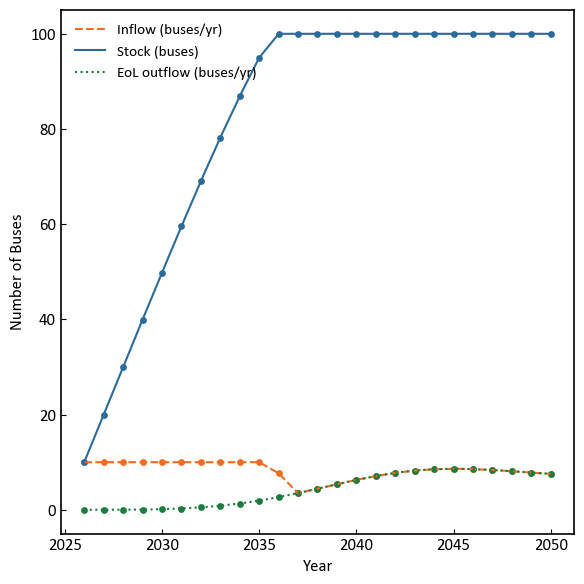

In [11]:
# 1) Fleet dynamics
bf.plot_fleet_dynamics(df_buses)

# # B) Annual mass of recycled Li used as input
# bf.plot_scenario_series(
#     series_dict=li_recycled,
#     years=MyYears,
#     title="Annual Recycled Lithium Input Mass",
#     ylabel="Recycled Li Input (kg/year)"
# )

# # C) Annual mass of Li recovered at EoL
# bf.plot_scenario_series(
#     series_dict=li_EOL_recycled,
#     years=MyYears,
#     title="Annual Lithium Recovered at End-of-Life",
#     ylabel="Recovered Li at EoL (kg/year)"
# )



# # 3D lines + shaded area for inputs
# bf.plot_3d_li_input_lines(
#     years       = MyYears,
#     total_li    = {sc: total_li_in    for sc in demand_share},
#     li_recycled = li_recycled
# )

# # 3D lines + shaded area for EoL outputs
# bf.plot_3d_li_output_lines(
#     years        = MyYears,
#     total_li_EOL = {sc: total_li_EOL   for sc in eol_share},
#     li_recovered = li_EOL_rec
# )

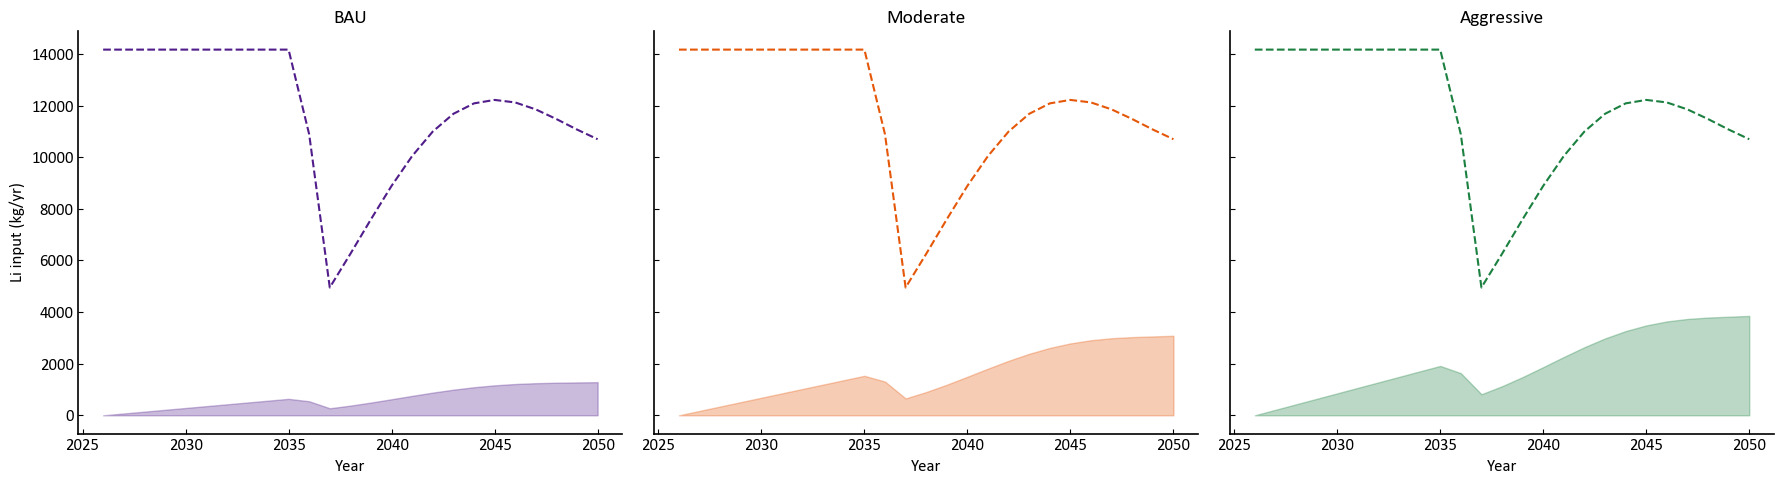

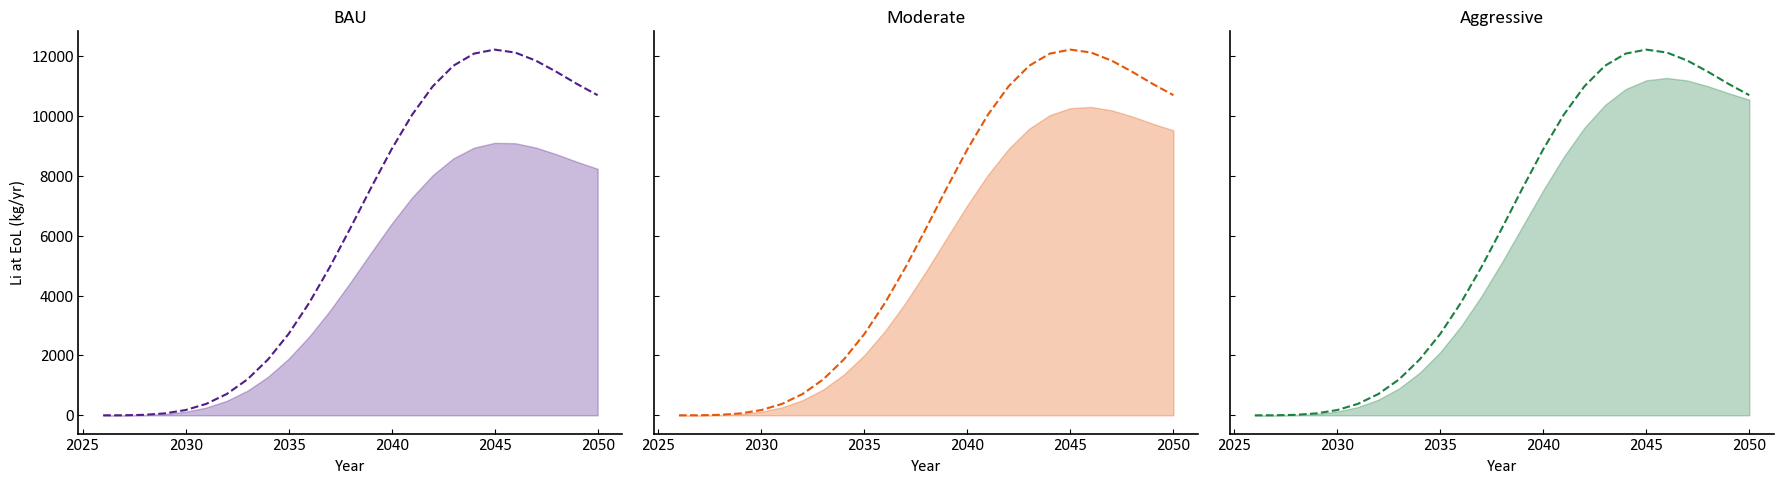

In [12]:
import matplotlib.pyplot as plt

# Your new palette
scen_colors = {
    'BAU':        '#501d8a',
    'Moderate':   '#e55709',
    'Aggressive': '#1c8041',
}

# Common rcParams
plt.rcParams.update({
    'font.family':    'calibri',
    'font.size':      12,
    'axes.linewidth': 1.2,
    'axes.grid':      False,
    'xtick.direction':'in',
    'ytick.direction':'in'
})

scenarios = ['BAU','Moderate','Aggressive']

# --- Figure 1: Li INPUT ---
fig, axes = plt.subplots(1, 3, figsize=(18,5), sharey=True)
for ax, scen in zip(axes, scenarios):
    total    = total_li_in
    recycled = li_recycled[scen]
    color    = scen_colors[scen]

    # total dashed line in your scen color
    ax.plot(MyYears, total,
            linestyle='--',
            color=color,
            lw=1.5,
            label='Total input')

    # recycled fill
    ax.fill_between(MyYears, 0, recycled,
                    color=color,
                    alpha=0.3,
                    label='Recycled')

    # clean up
    ax.set_title(scen, fontsize=14)
    ax.set_xlabel('Year')
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axes[0].set_ylabel('Li input (kg/yr)')
# axes[0].legend(loc='upper left')
plt.tight_layout()
plt.show()


# --- Figure 2: Li at EoL ---
fig, axes = plt.subplots(1, 3, figsize=(18,5), sharey=True)
for ax, scen in zip(axes, scenarios):
    total = total_li_EOL
    recov = li_EOL_rec[scen]
    color = scen_colors[scen]

    ax.plot(MyYears, total,
            linestyle='--',
            color=color,
            lw=1.5,
            label='Total EoL')

    ax.fill_between(MyYears, 0, recov,
                    color=color,
                    alpha=0.3,
                    label='Recovered')

    ax.set_title(scen, fontsize=14)
    ax.set_xlabel('Year')
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axes[0].set_ylabel('Li at EoL (kg/yr)')
# axes[0].legend(loc='upper left')
plt.tight_layout()
plt.show()
